In [1]:
## Importing dependencies
## Author Kriti Garg, IIT Roorkee
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from gc import collect
import pprint
from colorama import Fore, Style, init;
from warnings import filterwarnings;
filterwarnings('ignore');

In [2]:
# Nice helper function from https://www.kaggle.com/code/ravi20076/optiver-baseline-models
def PrintColor(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    "Prints color outputs using colorama using a text F-string";
    print(style + color + text + Style.RESET_ALL); 

In [3]:
tf.random.set_seed(42) # tf randomization

If the operation seed is set, but the global seed is not set: A default global seed and the specified operation seed are used to determine the random sequence.

In [4]:
# Importing the datasets
train = pd.read_csv(r'/kaggle/input/optiver-trading-at-the-close/train.csv')#training dataset
test = pd.read_csv(r'/kaggle/input/optiver-trading-at-the-close/example_test_files/test.csv')#testing-dataset
collect();

In [5]:
# We only need the targets from the training data as we are going to build a time series model for it.
train.sort_values(by=['stock_id', 'date_id', 'seconds_in_bucket'], inplace=True) # sorting values by the following columns
targets_df = pd.DataFrame(train[['stock_id', 'date_id', 'seconds_in_bucket', 'target']])
collect();

In [6]:
# We can also make a revealed targets dataframe (similar to in the test case)
# We get all the targets for the previous days, to ensure there is no leakage we enable a date access column so we can't access dates for the same day
unique_dates = test.date_id.unique()
revealed_targets_test = pd.DataFrame()
targets, dates, access_dates, stocks = [], [], [], []

for date in unique_dates:
    targets.append(train.loc[train.date_id == date]['target'])
    dates.append(train.loc[train.date_id == date - 1]['date_id'])
    access_dates.append(train.loc[train.date_id == date]['date_id'])
    stocks.append(train.loc[train.date_id == date]['stock_id'])

# flatten the n x 3 arrays so they can be added to the dataframe
    
revealed_targets_test['revealed_target'] = np.array(targets).flatten()
revealed_targets_test['date_id'] = np.array(dates).flatten()
revealed_targets_test['access_date_id'] = np.array(access_dates).flatten()
revealed_targets_test['stock_id'] = np.array(stocks).flatten()
collect();

## Multivariate Data Preprocessing

In [7]:
# changing the date to be multivariate where the features are stocks
def split_stocks(df, target_col='target'):
    y = pd.DataFrame()
    # iterate over each stock in the dataframe and assign them to a new df y
    for stock in df.stock_id.unique():
        y[f'stock_{stock}'] = df.loc[df.stock_id == stock][target_col]
    return y
collect();

In [8]:
# note we cannot run this as there are missing values for certain stocks
# we can find the number of na values too, but that's not our agenda
#y = split_stocks(targets_df)

In [9]:
%%time # for checking how much time is required
# can we create a new dataframe that includes NaN values when a stock doesnt have a value for that date

# this method is quicker but still slow (any suggestions to improve this are welcome)
def rearrange_df(df, target_col='target'):
    # start by getting the unique values of each date, stock and seconds
    unique_dates = df.date_id.unique()
    unique_stocks = df.stock_id.unique()
    unique_seconds = df.seconds_in_bucket.unique()
    
    cols = list(unique_stocks)
    cols.append('date_id')
    cols.append('seconds_in_bucket')
    # init a df that values can be placed in
    d = pd.DataFrame([np.zeros(202)], columns=cols)
    
    for date in unique_dates:
        # get the values for the date_id == date
        date_df = df.loc[df.date_id == date]
        for seconds in unique_seconds:
            # get the values for the seconds_in_bucket == seconds at date_id == date
            seconds_df = date_df[date_df.seconds_in_bucket == seconds]

            # list of stock_ids that have values at this time point, to be used as columns for temp df
            columns = list(seconds_df.stock_id.values)
            columns.append('date_id')
            columns.append('seconds_in_bucket')

            # list of target values, date_id and seconds_in_bucket for the given time point
            values = list(seconds_df[target_col].values)
            values.append(date)
            values.append(seconds)

            # init df with these values and concat with first df
            seconds_df_new = pd.DataFrame([values], columns=columns)
            d = pd.concat([d, seconds_df_new], axis=0, ignore_index=True)

    return d

d = rearrange_df(targets_df)

# drop the row used in the initialisation
d.drop(0, axis=0, inplace=True)
print(d.head(3))
collect();

          0         1         2         3         4         5         6  \
1 -3.029704 -5.519986 -8.389950 -4.010200 -7.349849  6.779432 -2.499819   
2  0.389814 -1.620054 -7.460117 -1.040101 -6.719828  7.710457 -4.280209   
3  4.220009 -6.459951 -6.380081 -2.030134 -0.690222  1.009703  2.930164   

           7         8         9  ...        192       193       194  \
1  -1.959801 -5.970001  7.970333  ... -11.529922 -6.489754  3.999472   
2  -8.010268 -0.780225 -0.640154  ... -15.599728 -1.749992 -9.030104   
3 -12.069941 -4.119873 -3.250241  ... -12.710094  2.160072 -9.999871   

        195       196       197       198  199  date_id  seconds_in_bucket  
1 -0.690222 -0.810027 -8.440018 -0.510216  NaN      0.0                0.0  
2 -1.320243 -3.259778 -4.410148 -1.419783  NaN      0.0               10.0  
3  5.890131 -0.029802 -6.819964  2.599955  NaN      0.0               20.0  

[3 rows x 202 columns]
CPU times: user 6min 53s, sys: 565 ms, total: 6min 54s
Wall time: 6min 50s


### Investigating missing values
##### We already know there are missing values for stocks at specific timepoints, can we see whether they are distributed evenly or they are for one specific stock.

---Percentage of targets that are missing for each stock---


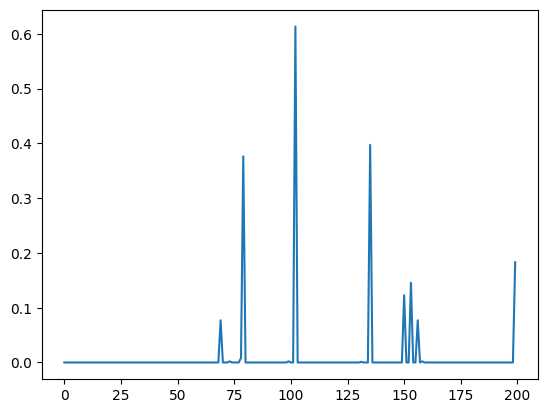

In [10]:
numerical_d = d.drop(['date_id', 'seconds_in_bucket'], axis=1)
PrintColor('---Percentage of targets that are missing for each stock---')
plt.plot(numerical_d.isna().sum() / len(numerical_d))
plt.show()
collect();

In [11]:
# for now just fill the missing values with 0s, in future use more complex ways to impute NaNs e.g impute the mean value, use a simple ARIMA model, or a generative n-network
numerical_d.fillna(0, inplace=True)

### Normalisation

It helps in convering of gradients faster and also helps in feature scaling so thay no feature gets an advantage

In [12]:
scaler = MinMaxScaler(feature_range=(-1, 1))
# Normalise and fit the data (only to be used on the training set)
def normalise_and_fit(df):
    df = df.copy()
    df[df.columns] = scaler.fit_transform(df[df.columns])
    return df

# Just normalise the data, used in test and validation
def normalize_df(df):
    df = df.copy()
    df[df.columns] = scaler.transform(df[df.columns])
    return df

# different helper function for just 1D arrays
def normalize_1D_array(arr, n_samples=1, n_features=200):
    arr = scaler.transform(X.reshape(n_samples, n_features))
    return arr

In [13]:
normalised_numerical_df = normalise_and_fit(numerical_d) # normalizing the data

### Training

We may split with some other ratio too, shuffle=False is important to keep the sequential information intact

In [14]:
# gets close to 60% train, 15% validation, 15% test
train, test_df = train_test_split(normalised_numerical_df, train_size = .85, random_state=42, shuffle=False)
train_df, val_df = train_test_split(train, train_size=12/17, random_state=42, shuffle=False)

In [15]:
input_series_length = 55
output_series_length = 55
n_features = 200
batch_size = 128
n_samples = len(train) // batch_size

In [16]:
# used a research papet to replicate this approach (has been shared in github)
def multivariate_multioutput_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])
    
    return np.array(data), np.array(labels)

In [17]:
train_X, train_y = multivariate_multioutput_data(train_df.to_numpy(), train_df.to_numpy(), 0, None, input_series_length, output_series_length, 1)
val_X, val_y = multivariate_multioutput_data(val_df.to_numpy(), val_df.to_numpy(), 0, None, input_series_length, output_series_length, 1)
test_X, test_y = multivariate_multioutput_data(test_df.to_numpy(), test_df.to_numpy(), 0, None, input_series_length, output_series_length, 1)

In [18]:
print (train_X.shape,
       train_y.shape,
       val_X.shape,
       val_y.shape,
       'Single window of past history : {}'.format(train_X[0].shape),
       'Target window to predict : {}'.format(train_y[0].shape),
       sep='\n')

(15762, 55, 200)
(15762, 55, 200)
(6504, 55, 200)
(6504, 55, 200)
Single window of past history : (55, 200)
Target window to predict : (55, 200)


In [19]:
train_data_multi = tf.data.Dataset.from_tensor_slices((train_X, train_y))
train_data_multi = train_data_multi.batch(batch_size).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((val_X, val_y))
val_data_multi = val_data_multi.batch(batch_size).repeat()
collect();

## Model building

In [20]:
# Add the Time2Vec layer (modify 'output_dim' as needed)
model = Sequential()

# Add the LSTM layer with return_sequences=True
model.add(LSTM(200, activation='tanh', return_sequences=True, input_shape=(input_series_length, n_features)))

# Compile the model
model.compile(optimizer='adam', loss='mae', metrics=['mse', 'accuracy'])

# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 55, 200)           320800    
                                                                 
Total params: 320,800
Trainable params: 320,800
Non-trainable params: 0
_________________________________________________________________


Using early stopping to avoid stucking in plateau, when the validation loss hits saturation

In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights=True)

Storing the epoch results in 'history' variable, for plotting purpose and visualization

In [22]:
history = model.fit(train_data_multi, validation_data=val_data_multi, steps_per_epoch = n_samples, validation_steps=n_samples, epochs=100, verbose=1, callbacks=[early_stopping]).history

Epoch 1/100
175/175 [==============================] - 72s 397ms/step - loss: 0.0851 - mse: 0.0146 - accuracy: 0.2796 - val_loss: 0.0829 - val_mse: 0.0135 - val_accuracy: 0.3039
Epoch 2/100
175/175 [==============================] - 93s 531ms/step - loss: 0.0844 - mse: 0.0143 - accuracy: 0.2796 - val_loss: 0.0823 - val_mse: 0.0133 - val_accuracy: 0.3068
Epoch 3/100
175/175 [==============================] - 69s 392ms/step - loss: 0.0778 - mse: 0.0124 - accuracy: 0.3213 - val_loss: 0.0820 - val_mse: 0.0132 - val_accuracy: 0.3073
Epoch 4/100
175/175 [==============================] - 68s 391ms/step - loss: 0.0829 - mse: 0.0140 - accuracy: 0.2879 - val_loss: 0.0821 - val_mse: 0.0133 - val_accuracy: 0.3039
Epoch 5/100
175/175 [==============================] - 69s 392ms/step - loss: 0.0801 - mse: 0.0130 - accuracy: 0.3028 - val_loss: 0.0820 - val_mse: 0.0132 - val_accuracy: 0.3079
Epoch 6/100
175/175 [==============================] - 69s 397ms/step - loss: 0.0799 - mse: 0.0132 - accuracy:

## Plot

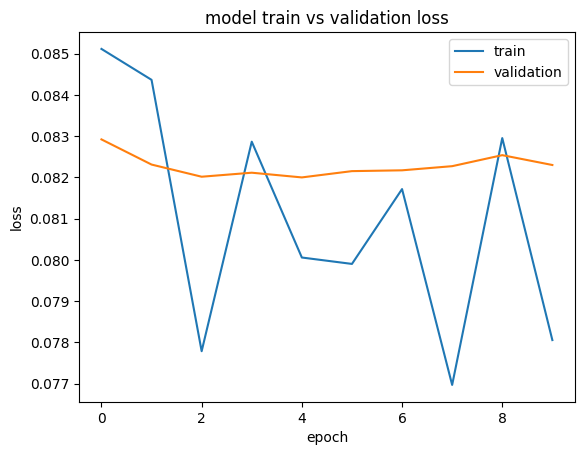

In [23]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Making Predictions

In [24]:
predictions = model.predict(test_X)
scaled_pred = scaler.inverse_transform(predictions.reshape(predictions.shape[0] * predictions.shape[1], predictions.shape[2]))
scaled_true = scaler.inverse_transform(test_y.reshape(predictions.shape[0] * predictions.shape[1], predictions.shape[2]))

121/121 [==============================] - 7s 50ms/step


In [25]:
PrintColor(f'MAE on normalised test data: {mae(test_y.flatten(), predictions.flatten())}')
PrintColor(f'MAE on test data: {mae(scaled_true, scaled_pred)}')

MAE on normalised test data: 0.07426444454707237
MAE on test data: 5.943275290057224


### Using the Optiver Environment
For submission as mentioned in the contest

In [26]:
predictions[0].shape # checking if the predictions is in right shape or not

(55, 200)

In [27]:
# return a full row of predictions
def invert(X):
    scaled_predictions = scaler.inverse_transform(X.reshape(1, 200))
    return scaled_predictions

In [28]:
import optiver2023 # importing the dependency as told in contest
env = optiver2023.make_env()
iter_test = env.iter_test()

In [29]:
for i, (test, revealed_targets, sample_prediction) in enumerate(iter_test):
    
    if i % 55 == 0:
        target_history = rearrange_df(revealed_targets, target_col='revealed_target')
        target_history.drop(['date_id', 'seconds_in_bucket'], axis=1, inplace=True)
        normalised_history = normalize_df(target_history)
        predictions = model.predict(np.array(normalised_history.iloc[-input_series_length:]).reshape(1, output_series_length, n_features), verbose=False)
        df = pd.DataFrame(predictions[0])
        normalised_history = pd.concat([normalised_history, df], ignore_index=True)
    pred = invert(normalised_history.iloc[55+(i%55)].to_numpy())
    sample_prediction['target'] = pred[0]
    env.predict(sample_prediction)
    collect();

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


In [30]:
sample_prediction.describe()

,target
count,200.000000
mean,-0.191537
std,1.088341
min,-5.614479
25%,-0.792665
50%,-0.100359
75%,0.509324
max,2.556439
